# MDI341 - Challenge 2019

## Introduction

This notebook presents a solution for the 2019 challenge for the MDI341 - Advanced Machine Learning course at Telecom ParisTech.

The goal of this challenge is to develop a binary classification system which tries to detect if an image contains some **property not** (that we can try to find out what they are)

### Properties of datasets
#### Training data:
The training set contains raw images and their labels. There are 116157 images in this dataset. Each image is of size 56 x 56 x 3 (the last dimension encodes the color information: red-green-blue). For each image there is a label, either 0 or 1.

#### Validation data:
The validation set only contains raw images. There are 27013 images in this dataset, where the image format is the same as before. The labels of this dataset will not be provided. Within the first phase, the ranks will be calculated based on this dataset.

#### Test data:
The test set only contains raw images as well. There will be 59429 images in this dataset, where the image format is the same as before. The labels of this dataset will not be provided either. This dataset will be provided only in the second phase: only a couple of hours before the challenge deadline. The final ranks will be calculated based on this dataset.

### The performance criterion
The data is highly unbalanced. Therefore, it was chosen a suitable criterion for evaluation: the performance criterion will be the average accuracy for each class, which is computed as follows:

$\text{score} = \frac1{2} \Biggl( \frac1{N_0}\sum_{i=1}^{N} (1-y_i)(1-\hat{y}_i) + \frac1{N_1}\sum_{i=1}^{N} y_i \hat{y}_i \Biggr)$

where $N$ denotes the total number elements of the dataset (it could be the training, validation or test set), $N_0$ denotes the number of elements whose labels are $0$, $N_1$ similarly denotes the number of elements whose labels are $1$, $y_i$ denotes the true label of the data sample $i$, and $\hat{y}_i$ denotes the predicted label for the data sample $i$.



## Tackling the challenge

In order to develop a classifeir model for image recognition I decided to use a deep-learning model based on CNNs: [DenseNet-BC](https://arxiv.org/pdf/1608.06993.pdf).

As I will show later, the samples of the validation set are actually already present in the training set, therefore I decided to not use it. In order to do cross-validation and find the best hyperparameters for the network, **I separated a different validation set from 20% of the training set**. 

I also decided to use a 5-fold technique in order to **train 5 models with the same architecture in different datasets in order to blend them at end**. This technique showed a big improvement in the score, **from 86.62% with one model to 87.27%, which placed me at the 2nd place of the challenge**.

As the dataset is unbalanced (c. 60% with label 1), the model is more likely to predict 1, therefore it will predict more false positives. In order to deal with that, **I decided to find a new the threshold of label decision using cross-validation, which showed to be around 0.57 instead of 0.50**. This is expected as, if we want our model to find less false positives we should increase the threshold. This technique improved the score by around 0.4%.

I used PyTorch as Deep Learning framework.

## Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

## Load data

In [15]:
# number of images
n_images = 116157
n_val_images = 27013

# size of the images 56*56 pixels in gray levels
image_dim = 56 * 56 * 3

labels = np.loadtxt('label_2019_train.txt', dtype=np.float64)

with open('db_train.raw', 'rb') as f:
    images = np.fromfile(f, dtype=np.uint8, count=n_images * image_dim).astype(np.float32)
    images = images.reshape(n_images, image_dim)
     
with open('db_val.raw', 'rb') as f:
    val_images = np.fromfile(f, dtype=np.uint8, count=n_val_images * image_dim).astype(np.float32)
    val_images = val_images.reshape(n_val_images, image_dim)
    
# Checking shapes of arrays
print(images.shape)
print(labels.shape)

print(val_images.shape)

(116157, 9408)
(116157,)
(27013, 9408)


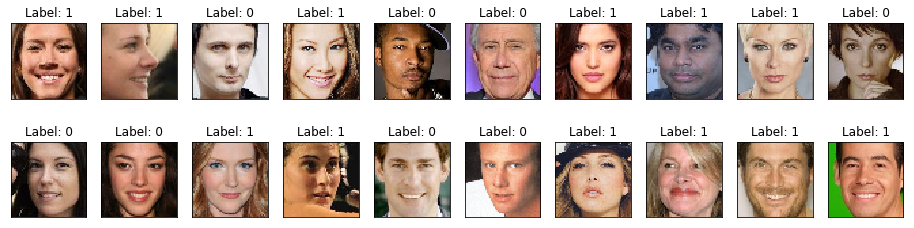

In [16]:
# Visualizing some images and their labels
ncols = 10

fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(16, 4))

for i, row in enumerate(axes):
  for j, ax in enumerate(row):
    ax.imshow(images[i*ncols+j].reshape(56, 56, 3).astype(np.uint8))
    ax.set_xticks([])
    ax.set_yticks([])    
    ax.set_title("Label: {}".format(int(labels[i*ncols+j])))

### Problem with validation set

I will show now that the validation samples are present in the training set

In order to show this I need to use a helper function that computes the distance between the images, I will use the distance L1 between the normalized pixels to compute these distances.

In [17]:
def distance(image1, image2):
    im1 = image1.flatten()
    im2 = image2.flatten()
    im1 /= 255
    im2 /= 255
    d = np.abs((im1 - im2)).sum()
    return d

Now I will use the first validation sample to find where the validation images are in the training set

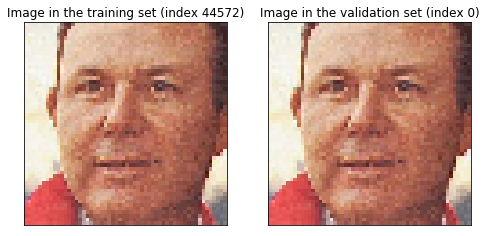

In [18]:
for i, train_im in enumerate(images):
    if distance(train_im, val_images[0]) == 0:
        # Keep the index of the image
        idx = i
        # Plotting both images to compare
        fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
        axes[0].imshow(train_im.reshape(56, 56, 3).astype(np.uint8))
        axes[0].set_title('Image in the training set (index {})'.format(idx))
        axes[0].set_xticks([])
        axes[0].set_yticks([])   
        axes[1].imshow(val_images[0].reshape(56, 56, 3).astype(np.uint8))
        axes[1].set_title('Image in the validation set (index 0)')
        axes[1].set_xticks([])
        axes[1].set_yticks([])   
        break

The images are not even shuffled, we can find the samples of the validation set by just looking at images after the index 44572:

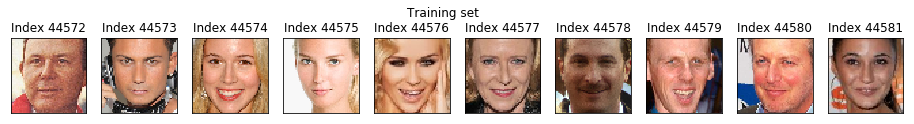

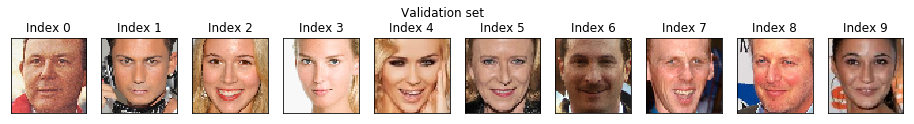

In [19]:
ncols = 10

# Printing images of the training set
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(16, 2))
for i, ax in enumerate(axes):
    ax.imshow(images[idx+i].reshape(56, 56, 3).astype(np.uint8))
    ax.set_xticks([])
    ax.set_yticks([])    
    ax.set_title('Index {}'.format(idx+i))
    plt.suptitle('Training set')
    
# Printing images of the validation set
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(16, 2))
for i, ax in enumerate(axes):    
    ax.imshow(val_images[i].reshape(56, 56, 3).astype(np.uint8))
    ax.set_xticks([])
    ax.set_yticks([])    
    ax.set_title('Index {}'.format(i))
    plt.suptitle('Validation set')

Knowing that, I decided to split a validation set from the training set randomly (20% of the samples), in order to perform hold-out cross-validation. 

## Preparing data

I decided to use hold-out cross-validation due to the time constraints, since each training took around 1h, training the same model on 5-folds would take 5 hours for each set of paramaters we are using.

After finding the best hyperparamters I therefore used a 5-fold to train 5 different models to blend them at the end.

In [20]:
DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'
BATCH_SIZE = 128
VALID_SIZE = 0.2
# Number that track which fold we are working with
CV = 1

In [21]:
# Transforming numpy to tensors
images = torch.Tensor(images).view(-1, 56, 56, 3).permute(0,3,1,2)
labels = torch.Tensor(labels).type(torch.LongTensor)

# Obtain training indices that will be used for validation, after shuffling them
num_train = len(images)
indices = list(range(num_train))
np.random.seed(0)
np.random.shuffle(indices)
split = int(np.floor(VALID_SIZE * num_train))
train_idx = indices[:(CV-1)*split] + indices[CV*split:] 
valid_idx = indices[(CV-1)*split:CV*split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(list(zip(images, labels)), batch_size=BATCH_SIZE, sampler=train_sampler)
valid_loader = DataLoader(list(zip(images, labels)), batch_size=BATCH_SIZE, sampler=valid_sampler)

## Network architecture - DenseNet-BC

The model I chose was a variant of the [DenseNet-BC](https://arxiv.org/pdf/1608.06993.pdf). I decided to use it because it has showed to provide really good results while having less parameters than others architectures (as ResNet). This is obtained by the several conections beetwen the layers and concatenations with inputs of previous layers (which explains the name "Dense").

This architecture is comprised of Dense Blocks as showed in the figure below:

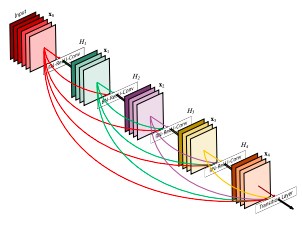
<center>A 5-layer dense block with a growth rate of k 4. Each layer takes all preceding feature-maps as input<center>

A particularity of the layers in each dense block is the use of Bottleneck layers (the B of BenseNet-BC). They are 1x1 convolutional layers used to reduce the feature-map before each convolution, as usually the input will have several features since they are concatenations of previous inputs with the current output. These layers are crucial for reducing running time during training.

**Defining the layers:**

In [22]:
class DenseLayer(nn.Module):
  
  def __init__(self, nChannels, growthRate, bottleneck, bnRate, dropout):
    super(DenseLayer, self).__init__()
    
    self.bottleneck = bottleneck
    
    if self.bottleneck:
      self.norm1 = nn.BatchNorm2d(nChannels)
      # Bottleneck convolution that reduces feature map dimensionality 
      self.conv1 = nn.Conv2d(nChannels, bnRate*growthRate, kernel_size=1, stride=1, 
                           padding=0, bias=False)
      self.norm2 = nn.BatchNorm2d(bnRate*growthRate)
      self.conv2 = nn.Conv2d(bnRate*growthRate, growthRate, kernel_size=3, stride=1, 
                           padding=1, bias=False)
    else:
      self.norm = nn.BatchNorm2d(nChannels)
      self.conv = nn.Conv2d(nChannels, growthRate, kernel_size=3, stride=1, 
                           padding=1, bias=False)
 
    # Dropout layer
    self.dropout = nn.Dropout2d(dropout)
  
  def forward(self, x):
    if self.bottleneck:
      out = self.conv1(F.relu(self.norm1(x)))
      out = self.conv2(F.relu(self.norm2(out)))
    else:
      out = self.conv(F.relu(self.norm(x)))
      
    out = self.dropout(out)
    return torch.cat([out, x], dim=1)
  

class DenseBlock(nn.Module):
  
  def __init__(self, nInput, nLayers, growthRate, bottleneck, bnRate, dropout):
    super(DenseBlock, self).__init__()
    layersList = []
    for i in range(nLayers):
      layersList.append(DenseLayer(nInput, growthRate, bottleneck, bnRate, dropout))
      nInput = nInput + growthRate
    self.block = nn.Sequential(*layersList)
   
  def forward(self, x):
    return self.block(x)

Each DenseBlock is connected by a Transition Layer where we apply a convolution followed by an average pooling.

At the end of the architecture we apply a linear layer with 2-dimension output as we are aim to have a binary classifier.

The overall structure of the model is find below:

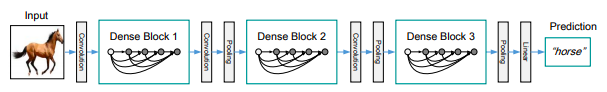
<center> A deep DenseNet with three dense blocks. The layers between two adjacent blocks are referred to as transition layers and change feature-map sizes via convolution and pooling <center>   

I also implemented the Compression technique described in the article (the C of DensetNet-BC). This technique is used to compress the model in order to optimize training. This compression is applied at each Transition Layer, reducing the size of the feature-map by a defined reduction rate. I used a reduction rate of 2.

**Defining the transition layers and the whole model:**

In [23]:
class TransitionLayer(nn.Module):
  
  def __init__(self, nInput, reductionRate):
    super(TransitionLayer, self).__init__()
    self.norm = nn.BatchNorm2d(nInput)
    nOutput = int(nInput // reductionRate)
    self.conv = nn.Conv2d(nInput, nOutput, kernel_size=1, stride=1, 
                          padding=1, bias=False)
    
  def forward(self, x):
    out = self.conv(F.relu(self.norm(x)))
    return F.avg_pool2d(out, 2)
  
      
class DenseNet(nn.Module):
  def __init__(self, nBlocks=3, nLayers=3, growthRate=16, reductionRate=2, 
               nChannelsInit=32, bottleneck=True, bnRate=4, dropout=0.1):
    super(DenseNet, self).__init__()
    
    # First convolution
    self.conv1 = nn.Conv2d(3, nChannelsInit, kernel_size=3, stride=1, padding=1, bias=False)
    
    # Creating list of blocks and transition layers
    layersList = []
    nInput = nChannelsInit
    for i in range(nBlocks):
      if i:
        layersList.append(TransitionLayer(nInput, reductionRate))
        nInput = int(nInput // reductionRate)
      layersList.append(DenseBlock(nInput, nLayers, growthRate, bottleneck, bnRate, dropout))
      nInput = nInput + nLayers*growthRate
    
    self.denseLayers = nn.Sequential(*layersList)
    
    # Fullyconnected layer
    self.norm1 = nn.BatchNorm2d(nInput)
    self.fc1 = nn.Linear(nInput, 2)
    
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.constant_(m.bias, 0)
    
  def forward(self, x):
    out = self.conv1(x)
    out = self.denseLayers(out)
    out = F.adaptive_avg_pool2d(F.relu(self.norm1(out)), 1).view(x.size(0),-1)
    out = self.fc1(out)
    return out 

Using hold-out cross validation I obtained the following hyperparameters as best:

In [24]:
nBlocks=4 # number of dense blocks
nLayers=6 # number of layers (bottleneck + conv 3x3) in each block
growthRate=16 # rate at which the feature map increases after each layer in the dense block
reductionRate=2 # reduction rate that reduces the feature map at each transition layer
nChannelsInit=32 # number of features in the first input
bnRate=4 # rate to obtain the output of each bottleneck layer - computed as bnRate*growthRate
dropout=0.1 # probability of dropout

In [25]:
# Generating our network
net = DenseNet(nBlocks=4, nLayers=6, growthRate=16, reductionRate=2, nChannelsInit=32, bnRate=4, dropout=0.1)
# Sending the model to gpu if it exists
net = net.to(DEVICE)

## Training

I trained the model for 40 epochs using the Adam optimizer with learning rate of 0.01 until the 20th epoch, than lr=0.001 from the 20th to the 30th epoch and finally lr=0.0001 until the end of the training.

Also, for each epoch I computed the loss and the accuracy on the validation set. Each time the model had lowest validation loss, I saved it as a checkpoint. Each time I reduced the learning rate (at 20th and 30th epochs) I loaded the best version of the model I had checkpointed.

This technique allowed the model to find a really good state where the validation loss was as minimum as it could be.

In [26]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.01)

In [27]:
# number of epochs to train the model
n_epochs = 40

valid_loss_min = np.Inf # track change in validation loss

t0 = time.time()

for epoch in range(1, n_epochs+1):

  # keep track of losses and accuracy
  train_loss = 0.0
  valid_loss = 0.0
  acc0 = 0.0
  acc1 = 0.0
  n0 = 0.0
  n1 = 0.0

  ###################
  # train the model #
  ###################
  net.train()
  for data, target in train_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(DEVICE), target.to(DEVICE)

    # clear the gradients of all optimized variables
    optimizer.zero_grad()

    output = net(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    # update training loss
    train_loss += loss.item()*data.size(0)

  ######################    
  # validate the model #
  ######################
  net.eval()
  net.eval()
  with torch.no_grad():
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(DEVICE), target.to(DEVICE)

        output = net(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)

        # cummulate accuracy
        _, pred = torch.max(output, 1)
        y0 = (target == 0)
        y1 = (target == 1)
        acc0 += (1-pred[y0]).sum().item()
        acc1 += (pred[y1]).sum().item()
        n0 += y0.sum().item()
        n1 += y1.sum().item()

  # calculate average losses
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)

  # calculate accuracy
  acc = ((acc0/n0)+(acc1/n1))/2

  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \t Accuracy: {:.6%}'.format(
      epoch, train_loss, valid_loss, acc))

  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
    torch.save(net.state_dict(), 'dense_net.pt')
    valid_loss_min = valid_loss
  
  if epoch == 20:
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.load_state_dict(torch.load('dense_net.pt'))
    
  if epoch == 30:
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    net.load_state_dict(torch.load('dense_net.pt'))       
        
t1 = time.time()

print("\nTotal time execution:", (t1-t0)/60,"min")

Epoch: 1 	Training Loss: 0.475925 	Validation Loss: 0.108405 	 Accuracy: 72.545222%
Validation loss decreased (inf --> 0.108405).  Saving model ...
Epoch: 2 	Training Loss: 0.385691 	Validation Loss: 0.086412 	 Accuracy: 78.699860%
Validation loss decreased (0.108405 --> 0.086412).  Saving model ...
Epoch: 3 	Training Loss: 0.334677 	Validation Loss: 0.080360 	 Accuracy: 79.800796%
Validation loss decreased (0.086412 --> 0.080360).  Saving model ...
Epoch: 4 	Training Loss: 0.310167 	Validation Loss: 0.074487 	 Accuracy: 80.919680%
Validation loss decreased (0.080360 --> 0.074487).  Saving model ...
Epoch: 5 	Training Loss: 0.295784 	Validation Loss: 0.068846 	 Accuracy: 83.892822%
Validation loss decreased (0.074487 --> 0.068846).  Saving model ...
Epoch: 6 	Training Loss: 0.283559 	Validation Loss: 0.069804 	 Accuracy: 82.765249%
Epoch: 7 	Training Loss: 0.276367 	Validation Loss: 0.066870 	 Accuracy: 83.339758%
Validation loss decreased (0.068846 --> 0.066870).  Saving model ...
Epo

We can notice that this model can already reach an accuracy of c. 86%, based on a threshold of 0.5 for the label decision.

The following step is to find the best threshold for this decision using the probababilities of label=1 for the validation set given by the model.

In [33]:
# Model in evaluation mode
net.eval()

# Initiate list of targets and probabilities
targets = np.zeros(0)
probs = np.zeros(0)

with torch.no_grad():
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        data = data.to(DEVICE)
        targets = np.concatenate((targets, target.numpy()))
        # The network outputs logits, therefore we should apply the softmax function in order to get the probabilities
        output = F.softmax(net(data), dim=1)
        output_probs = output.cpu().numpy()[:,1]
        probs = np.concatenate((probs, output_probs))

In [34]:
# Function to comput accuracy of predictions

def get_accuracy(y_true, y_pred):
    if(y_true.shape[0] != y_pred.shape[0]):
        raise Exception("y_pred and y_true must have the same size")
    tmp = np.unique(y_pred)
    if(tmp.shape[0] > 2):
        raise("y_pred should only contain 0 and 1")
        
    if(tmp.shape[0] == 1):
        if(tmp[0] != 0 and tmp[0] != 1):
            raise Exception("y_pred should only contain 0 and 1")
    else:
        if(tmp[0] != 0 and tmp[1] != 1):
            raise Exception("y_pred should only contain 0 and 1")
    
    y0 = (y_true == 0)
    y1 = (y_true == 1)
    
    acc1 = np.mean(1-y_pred[y0])
    acc2 = np.mean(y_pred[y1])
    
    return (acc1+acc2)/2

In [35]:
# Finding the best threshold

max_acc = 0

for threshold in np.arange(0.3, 0.7, 0.01):
    preds = (probs >= threshold).astype(int)
    acc = get_accuracy(targets, preds)
    print("Threshold: {:.2f}...  Accuracy: {:.6%}".format(threshold, acc))
    if acc > max_acc:
        max_acc = acc
        best_th = threshold

print("\nBest threshold: {:.2f}... Best accuracy: {:.6%}".format(best_th, max_acc))

Threshold: 0.30...  Accuracy: 83.239204%
Threshold: 0.31...  Accuracy: 83.478089%
Threshold: 0.32...  Accuracy: 83.622914%
Threshold: 0.33...  Accuracy: 83.828780%
Threshold: 0.34...  Accuracy: 84.067462%
Threshold: 0.35...  Accuracy: 84.242097%
Threshold: 0.36...  Accuracy: 84.389034%
Threshold: 0.37...  Accuracy: 84.500029%
Threshold: 0.38...  Accuracy: 84.686117%
Threshold: 0.39...  Accuracy: 84.846497%
Threshold: 0.40...  Accuracy: 84.971543%
Threshold: 0.41...  Accuracy: 85.068689%
Threshold: 0.42...  Accuracy: 85.177775%
Threshold: 0.43...  Accuracy: 85.300223%
Threshold: 0.44...  Accuracy: 85.540610%
Threshold: 0.45...  Accuracy: 85.654813%
Threshold: 0.46...  Accuracy: 85.764508%
Threshold: 0.47...  Accuracy: 85.783149%
Threshold: 0.48...  Accuracy: 85.865634%
Threshold: 0.49...  Accuracy: 85.946413%
Threshold: 0.50...  Accuracy: 86.011028%
Threshold: 0.51...  Accuracy: 86.115199%
Threshold: 0.52...  Accuracy: 86.163650%
Threshold: 0.53...  Accuracy: 86.132094%
Threshold: 0.54.

We can notice an improvement of 0.6% by increasing the threshold to 0.67. This is a pretty good achievement

## Predictions on test set

After training each of the 5 models (on each 5-fold) we compute the predictions using the chosen threshold and we also keep the probabilities. I will use both predictions and probabilities in order to find the best combination for the blending (majority vote or probability average)

In [37]:
n_images_test = 59429
with open('db_test.raw', 'rb') as f:
    images_test = np.fromfile(f, dtype=np.uint8, count=n_images_test * image_dim).astype(np.float32)
    images_test = images_test.reshape(n_images_test, image_dim)
    
# Sending test data to a loader
test_data = torch.Tensor(images_test).view(-1, 56, 56, 3).permute(0,3,1,2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [39]:
# Model in evaluation mode
net.eval()

# Initiating array of probabilities
probs_test = np.zeros(0)
with torch.no_grad():
    for data in test_loader:
        # move tensors to GPU if CUDA is available
        data = data.to(DEVICE)
        output = F.softmax(net(data), dim=1)
        output_probs = output.cpu().numpy()[:,1]
        probs_test = np.concatenate((probs_test, output_probs))

# Obtaining predictions with best threshold
preds_test = (probs_test >= best_th).astype(int)

In [ ]:
# Saving predictions and probabilities for the current fold
np.savetxt("val_pred{}.txt".format(CV), preds_test, fmt="%d")
np.savetxt("probs_test_cv{}.txt".format(CV), probs_test, fmt="%.8f")

## Blending

**Loading predictions and probabilities:**

In [4]:
pred1 = np.loadtxt("./outputs/val_pred1.txt", dtype=np.float64)
pred2 = np.loadtxt("./outputs/val_pred2.txt", dtype=np.float64)
pred3 = np.loadtxt("./outputs/val_pred3.txt", dtype=np.float64)
pred4 = np.loadtxt("./outputs/val_pred4.txt", dtype=np.float64)
pred5 = np.loadtxt("./outputs/val_pred5.txt", dtype=np.float64)

prob1 = np.loadtxt("./outputs/probs_test_cv1.txt", dtype=np.float64)
prob2 = np.loadtxt("./outputs/probs_test_cv2.txt", dtype=np.float64)
prob3 = np.loadtxt("./outputs/probs_test_cv3.txt", dtype=np.float64)
prob4 = np.loadtxt("./outputs/probs_test_cv4.txt", dtype=np.float64)
prob5 = np.loadtxt("./outputs/probs_test_cv5.txt", dtype=np.float64)

In [6]:
# Compute the blending predictions
blend_pred = (((pred1 + pred2 + pred3 + pred4 + pred5) / 5) > 0.5 ).astype(int)

Using the blending predictions I was able to get a score of around **87.10%**, but the best score was obtained by using the average of probabilities with a threshold of 0.57:

In [7]:
# Compute the blending probabilities
avg_prob = (prob1 + prob2 + prob3 + prob4 + prob5)

thr = 0.57
pred = (avg_prob > thr).astype(int)

With this predictions I obtained a score of around **87.23%**.

I was able to improve a little more by using a weighted average. Since a noticed the model trained on the first fold gave better results, I wheighted its predictions a little more:

In [8]:
avg_prob_weighted = (2*prob1 + prob2 + prob3 + prob4 + prob5)/6

thr = 0.57
pred = (avg_prob_weighted > thr).astype(int)

With these predictions I obtained a score of **87.27%**, the **2nd best score** of the ranking.